In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import  os
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from utils import Optuna_for_LGB
from preprocess import convert_notation, region_encoding, region_grouping
PATH = '../data/'
TRAIN = False

In [2]:
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')
train_df = convert_notation(train_df)
test_df = convert_notation(test_df)
train_df, test_df, le = region_encoding(train_df, test_df)
columns = list(test_df.columns)
columns.remove('index')
columns.remove('region')
train_df, test_df = region_grouping(train_df, test_df, columns, diff=True)
train_df, test_df = pd.get_dummies(train_df, columns=['region']), pd.get_dummies(test_df, columns=['region'])
all_df = pd.concat([train_df[test_df.columns], test_df])
all_df = all_df.reset_index(drop=True)
na_col = all_df.columns[all_df.isna().sum() > 0]
for col in na_col:
    all_df[col] = all_df[col].fillna(all_df[col].median())
train_df[test_df.columns] = all_df.iloc[:train_df.shape[0]]
test_df = all_df.iloc[train_df.shape[0]:]
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)
train_df.head()

(4043, 87) (4046, 86)


,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_10,region_11,region_12,region_13,region_14,region_15,region_16,region_17,region_18,region_19
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,0,0,0,0
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,0,0,0,0
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,0,0,0,0
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,0,0,0,0
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,0,0,0,0,0,1


In [3]:
train_df.columns, test_df.columns

(Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'tempo', 'tempo_min', 'tempo_max',
        'popularity_mean', 'popularity_std', 'duration_ms_mean',
        'duration_ms_std', 'acousticness_mean', 'acousticness_std',
        'positiveness_mean', 'positiveness_std', 'danceability_mean',
        'danceability_std', 'loudness_mean', 'loudness_std', 'energy_mean',
        'energy_std', 'liveness_mean', 'liveness_std', 'speechiness_mean',
        'speechiness_std', 'instrumentalness_mean', 'instrumentalness_std',
        'tempo_mean', 'tempo_std', 'tempo_min_mean', 'tempo_min_std',
        'tempo_max_mean', 'tempo_max_std', 'popularity_region_mean_diff',
        'popularity_region_mean_diff_region_std_diff',
        'duration_ms_region_mean_diff',
        'duration_ms_region_mean_diff_region_std_diff',
        'acousticness_region_mean_diff',
        'ac

In [5]:
%%capture
columns = list(test_df.columns)
columns.remove('index')
ss_columns = columns.copy()
[ss_columns.remove('region_{0}'.format(i)) for i in np.arange(20)]
region_col = ['region_{0}'.format(i) for i in np.arange(20)]
kf = LeaveOneOut()
name = 'knn_group'
x, y = train_df[columns], train_df.genre
score = list()
n_neighbors = 1
metric = 'euclidean'
if TRAIN:
    for cv, (train_idx, test_idx) in enumerate(kf.split(x)):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        ss = StandardScaler()
        x_train[ss_columns] = ss.fit_transform(x_train[ss_columns])
        x_test[ss_columns] = ss.transform(x_test[ss_columns])

        x_train[region_col] /= 100.0
        x_test[region_col] /= 100.0

        knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1, metric=metric)
        knn.fit(x_train, y_train)
        pd.to_pickle(knn, '../model/leave_one_out/{0}_{1}_{2}/knn_{3}.pkl'.format(name, metric, n_neighbors, cv))
        pd.to_pickle(ss, '../model/leave_one_out/{0}_{1}_{2}/ss_{3}.pkl'.format(name, metric, n_neighbors, cv))
        score.append(f1_score(knn.predict(x_test), y_test, average='macro'))

In [5]:
np.mean(score), np.std(score)

(0.5716052436309671, 0.4948461266742924)

In [7]:
%%capture
sub_df = pd.read_csv(PATH + 'sample_submit.csv', header=None, names=['ID', 'Pred'])
prediction = np.zeros((test_df.shape[0], 11), dtype=np.float64)
for i in range(train_df.shape[0]):
    x = test_df[columns].copy()
    model = pd.read_pickle('../model/leave_one_out/{0}_{1}_{2}/knn_{3}.pkl'.format(name, metric, n_neighbors, i))
    ss = pd.read_pickle('../model/leave_one_out/{0}_{1}_{2}/ss_{3}.pkl'.format(name, metric, n_neighbors, i))
    x[ss_columns] = ss.transform(x[ss_columns])
    x[region_col] /= 100.0
    pred = model.predict_proba(x).astype(np.float64)
    prediction += pred
prediction /= train_df.shape[0]
sub_df.Pred = np.argmax(prediction, axis=1)
sub_df.head()

<AxesSubplot:>

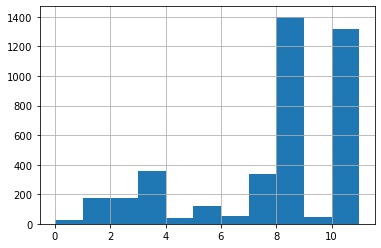

In [8]:
sub_df.Pred.hist(range=(0,11), bins=11)

In [10]:
sub_df.to_csv('../pred/{0}_{1}_{2}.csv'.format(name, metric, n_neighbors), index=None, header=None)